In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import napari
from matplotlib import pyplot as plt  # graphic library, for plots
import numba as nb

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.plotting import figure, show
from bokeh.sampledata.stocks import AAPL

In [3]:
output_notebook()

Loading BokehJS ...

In [4]:
import filedialogs

In [5]:
from metavision_core.event_io.raw_reader import RawReader
from metavision_core.event_io.py_reader import EventDatReader
from metavision_core.event_io import EventsIterator

In [29]:
dt=1000

In [6]:
path = filedialogs.gui_fname('example_data/')
path = path.decode('ascii')

In [7]:
record_raw = RawReader(path)
print(record_raw)

RawReader(E:/code/github-ffvoigt/accordion/playground/example_data/fish_bouts_recording_2023-06-27_10-42-58.raw)
current time : 0us done : False
current event index : 0
_begin_buffer 0,_end_buffer_ 0,  buffer_size 10000000


In [8]:
events = record_raw.load_n_events(1000000)
print(events)

[(834, 596, 1,     8214) (925,   4, 0,     9194) (767, 127, 0,     9410)
 ... (829, 542, 0, 15191063) (771, 162, 0, 15191064)
 (810, 484, 0, 15191067)]


In [9]:
events['t'].max()

15191067

In [10]:
events['t'].max()/1000/1000

15.191066999999999

In [11]:
def calculate_bins(events, dt=1000):
    # calculate events for timestep dt in us
    min_timepoint = events['t'].min()
    max_timepoint = events['t'].max()
    interval_us = max_timepoint-min_timepoint
    timepoints = int(interval_us / (dt))
    bins = np.linspace(min_timepoint, max_timepoint, timepoints)
    return bins

def calculate_bin_number(events, dt=1000):
    # calculate events for timestep dt in us
    min_timepoint = events['t'].min()
    max_timepoint = events['t'].max()
    timepoints = int(np.floor((max_timepoint-min_timepoint) / (dt)))
    return timepoints

In [12]:
@nb.njit
def inside_circle(x, y, x_center, y_center, r):
    return np.power(x-x_center,2)+np.power(y-y_center,2) <= np.power(r,2)

def is_on_event(event):
    return event[2]==1

@nb.njit
def filter_array(arr, condition):
    result = np.empty_like(arr)
    j = 0
    for i in range(arr.size):
        if condition(arr[i]):
            result[j] = arr[i]
            j += 1
    return result[:j].copy()

In [13]:
@nb.njit
def events_inside_circular_roi(events, x_center, y_center, radius):
    result = np.empty_like(events)
    j = 0
    for i in range(events.size):
        if inside_circle(events[i]['x'],events[i]['y'],x_center,y_center, radius):
            result[j] = events[i]
            j += 1
    return result[:j].copy()

In [14]:
@nb.njit
def split_events(events):
    on_events = np.empty_like(events)
    off_events = np.empty_like(events)
    on_counter = 0
    off_counter = 0
    
    for i in range(events.size):
        if events[i][2]==1:
            on_events[on_counter] = events[i]
            on_counter += 1
        else: 
            off_events[off_counter] = events[i]
            off_counter += 1
   
    return on_events[:on_counter].copy(),off_events[:off_counter].copy()

In [15]:
def viz_events(events, height, width):
    img = np.full((height, width, 3), 128, dtype=np.uint8)
    img[events['y'], events['x']] = 255 * events['p'][:, None]
    return img

In [16]:
inside_events = events_inside_circular_roi(events, 560, 375, 400)
on_events, off_events = split_events(inside_events)

In [17]:
len(inside_events)

225214

In [18]:
bins = calculate_bin_number(events, dt=1000)

In [19]:
bins

15182

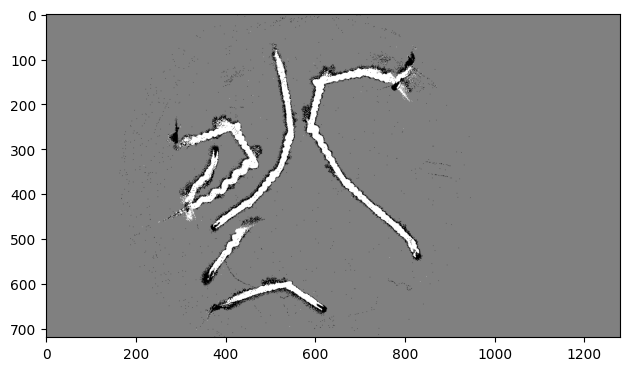

In [20]:
height, width = record_raw.get_size()

# load the next 50 ms worth of events
# events = record_raw.load_delta_t(50000)
im = viz_events(inside_events, height, width)

plt.imshow(im)
plt.tight_layout()

Note: The on/off edges are slightly different as the event timestamps are slightly different 
* might be solvable by shifting the first and the last events in time?
* or hardcoding the edges based on the original event data?

In [21]:
on_hist, on_edges = np.histogram(on_events['t'], density=False, bins=bins)
off_hist, off_edges = np.histogram(off_events['t'], density=False, bins=bins)
on_edges = on_edges[1:]
off_edges = off_edges[1:]

### Numpy arrays have names for columns!

In [ ]:
events.dtype.names

### Pyqtgraph Helper Tool

In [22]:
%gui qt5
from PyQt5.Qt import QApplication
import qdarkstyle
import pyqtgraph as pg

In [23]:
# start qt event loop
_instance = QApplication.instance()
if not _instance:
    _instance = QApplication([])
app = _instance

In [32]:
class EventExplorer():
    def __init__(self):
        self.graphicsView = pg.GraphicsView()
        self.graphicsView.setWindowTitle('Event Explorer')
        self.layout = pg.GraphicsLayout()
        self.graphicsView.setCentralItem(self.layout)
        self.graphicsView.show()
        
        self.XY_plot = self.layout.addPlot(row=0, col=0, rowspan=2, colspan=1)
        self.ET_plot = self.layout.addPlot(row=2, col=0, rowspan=1, colspan=2)
        self.ET_region_selection_plot = self.layout.addPlot(row=3, col=0, rowspan=1, colspan=2)
        self.YT_plot = self.layout.addPlot(row=0, col=3)
        self.XY_plot.setAspectLocked(True, ratio=1.77)
        self.XY_plot.invertY(True)
        self.YT_plot.invertY(True)
        self.YT_plot.enableAutoRange()
        
        self.ET_plot.plot(x = on_edges, y = on_hist, pen="b")
        self.ET_plot.plot(x = on_edges, y = on_hist+off_hist, pen="r")
        self.ET_region_selection_plot.plot(x = on_edges, y = on_hist+off_hist, pen="r")
        
        len_data = len(on_hist)
        left_start_range = on_edges[int(len_data/3)]
        right_start_range = on_edges[int(2*len_data/3)] 
        
        self.ET_region = pg.LinearRegionItem(values=[left_start_range,right_start_range])
        self.ET_region.setZValue(10) # Move item up
        self.ET_region_selection_plot.addItem(self.ET_region, ignoreBounds = True)
        self.ET_plot.setAutoVisible(y=True)
        
        self.s4 = pg.ScatterPlotItem(
            size=3,
            pen=pg.mkPen(None),
            brush=pg.mkBrush(255, 255, 255, 20))

        self.s4.addPoints(x=on_events['x'],
            y=on_events['y'],
                # size=(np.random.random(n) * 20.).astype(int),
            #brush=[pg.mkBrush(x) for x in np.random.randint(0, 256, (len(on_events), 3))],
                #data=np.arange(n)
                )

        self.XY_plot.addItem(self.s4)
        
        self.s5 = pg.ScatterPlotItem(
            size=3,
            pen=pg.mkPen(None),
            brush=pg.mkBrush(255, 255, 255, 20))
        
        self.YT_plot.addItem(self.s5)
        
        #ET_plot.sigRangeChanged.connect(updateRegion) 
        self.ET_region.sigRegionChanged.connect(self.update)
        
    def updateRegion(self, window, viewRange):
        rgn = viewRange[0]
        self.ET_region_selection_plot.setRegion(rgn)

    def event_time_slice(self, events, t_start, t_stop):
        start_index = int(np.sum(on_hist[0:int(np.floor((t_start-on_edges[0])/dt))]))
        stop_index = int(np.sum(on_hist[0:int(np.ceil((t_stop-on_edges[0])/dt))]))
        return events[start_index:stop_index]

    def update_XY_plot(self, events_subset):
        self.s4.clear()
        self.s4.addPoints(x=events_subset['x'],
                y=-events_subset['y']+720,
                     )

    def update_YT_plot(self, events_subset):
        self.s5.clear()
        self.s5.addPoints(x=events_subset['t'],
                y=-events_subset['y']+720,
                     )

    def update(self):
        self.ET_region.setZValue(10)
        minX, maxX = self.ET_region.getRegion()
        self.ET_plot.setXRange(minX, maxX, padding=0)
        events_subset = self.event_time_slice(on_events, minX, maxX)
        self.update_XY_plot(events_subset)
        self.update_YT_plot(events_subset)

In [33]:
myexplorer2 = EventExplorer()

In [ ]:
%gui qt5
from PyQt5.Qt import QApplication
import qdarkstyle
import pyqtgraph as pg

dt=1000 # bin interval in us!

# start qt event loop
_instance = QApplication.instance()
if not _instance:
    _instance = QApplication([])
app = _instance



def updateRegion(window, viewRange):
    rgn = viewRange[0]
    ET_region_selection_plot.setRegion(rgn)
    
def event_time_slice(events, t_start, t_stop):
    start_index = int(np.sum(on_hist[0:int(np.floor((t_start-on_edges[0])/dt))]))
    stop_index = int(np.sum(on_hist[0:int(np.ceil((t_stop-on_edges[0])/dt))]))
    return events[start_index:stop_index]
    
def update_XY_plot(events_subset):
    s4.clear()
    s4.addPoints(x=events_subset['x'],
            y=-events_subset['y']+720,
                 )
    
def update_YT_plot(events_subset):
    s5.clear()
    s5.addPoints(x=events_subset['t'],
            y=-events_subset['y']+720,
                 )
    
def update():
    ET_region.setZValue(10)
    minX, maxX = ET_region.getRegion()
    ET_plot.setXRange(minX, maxX, padding=0)
    events_subset = self.event_time_slice(on_events, minX, maxX)
    update_XY_plot(events_subset)
    update_YT_plot(events_subset)
    
#ET_plot.sigRangeChanged.connect(updateRegion) 
ET_region.sigRegionChanged.connect(update)



In [ ]:
on['events']

In [ ]:
np.cumsum(on_hist[0:int(np.floor((t_start-on_edges[0])/dt))])

In [ ]:
np.max(on_events['y'])

In [ ]:
len(on_events)

In [ ]:
on_events['t'][-1]

In [ ]:
np.max(np.cumsum(on_hist))

In [ ]:
np.arange(0,len(on_edges))

In [ ]:
np.cumsum(on_hist[0])

In [ ]:
plt.plot(np.arange(0,len(on_edges)), np.cumsum(on_hist))

In [ ]:
def 

In [ ]:
8062910.12239982<on_events['t']<8390959.26645485

In [ ]:
N = 100
Z = np.random.normal(size = N)
# method 1
H,X1 = np.histogram( Z, bins = 10, normed = True )
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
#method 2
X2 = np.sort(Z)
F2 = np.array(range(N))/float(N)

plt.plot(X1[1:], F1)
plt.plot(X2, F2)
plt.show()